# Simulating Images from the MAST telescope

In this project, we use data from the Gaia telescope and create an image which will be captured by the CCD on the MAST telescope. This will be helpful for the tracking and guiding of the telescope.

In [1]:
# Import the required libraries

# astroquery for retrieving data from Gaia
from astroquery.gaia import Gaia

# astropy libraries for calculations
from astropy import units as u
from astropy import wcs
from astropy.constants import h, c
from astropy import convolution

# Data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib ipympl
from scipy import signal
from scipy.interpolate import CubicSpline
from PIL import Image

# Manipulating & parsing files
import re
import os
from glob import glob

# Making the notebook interactive
import ipywidgets as widgets
from IPython.display import display

In order to use this notebook, please first run all of the cells. You will get textboxes to fill the desired coordinates, different parameters, etc. Then, you can press the button "Simulate Imgae", that will save the image in the requested path.

In [2]:
# Defining the constants of the notebook

# Constants from files
qe = pd.read_csv('./essential_files/ccd_data/QE.csv', delimiter=',') # Quantum Efficiency
dark = pd.read_csv('./essential_files/ccd_data/dark_current.csv', delimiter=',') # Dark Current

# Gaia Flux Density
fd_unit = u.J/u.m**2/u.s/u.nm
d_filters = {'Band':['G','BP','RP'],'Wavelength':[639.07*u.nm,518.26*u.nm,782.51*u.nm],'Bandpass':[454.82*u.nm,265.9*u.nm,292.75*u.nm],'clam':[1.346e-21*fd_unit,3.009e-21*fd_unit,1.638e-21*fd_unit]} 
filters = pd.DataFrame(data=d_filters)

# MAST CCD constants
# Pixels in the CCD
ccd_width_px = 4656
ccd_height_px = 3520

# Buffer of pixels when querying data and performing the convolution
ccd_width_buff_px = 512
ccd_height_buff_px = 512

# The lenght of each pixel in the CCD
ccd_px_side_length_micron = 3.8 * u.micron
ccd_width_micron = ccd_width_px * ccd_px_side_length_micron
ccd_height_micron = ccd_height_px * ccd_px_side_length_micron
ccd_width_buff_micron = ccd_width_buff_px * ccd_px_side_length_micron
ccd_height_buff_micron = ccd_height_buff_px * ccd_px_side_length_micron

# more MAST optical specs
mast_diameter = 0.6 * u.m
mast_collecting_area_m2 = (mast_diameter/2)**2 * np.pi * u.m**2
mast_focal_length = 1.8 * u.m
incoming_light_fov = 2*np.arctan(mast_diameter/2/mast_focal_length)

# The platescale of MAST
plate_scale_arcsec_micron = 206265 * u.arcsec / mast_focal_length.to(u.micron)

# Pixel field of view
plate_scale_arcsec_px = plate_scale_arcsec_micron * ccd_px_side_length_micron

# CCD field of view
ccd_width_range_arcsec = ccd_width_micron * plate_scale_arcsec_micron
ccd_height_range_arcsec = ccd_height_micron * plate_scale_arcsec_micron
ccd_width_buff_range_arcsec = ccd_width_buff_micron * plate_scale_arcsec_micron
ccd_height_buff_range_arcsec = ccd_height_buff_micron * plate_scale_arcsec_micron

# Converting from arcsec to degrees
ccd_width_range_deg = ccd_width_range_arcsec.to(u.deg)
ccd_height_range_deg = ccd_height_range_arcsec.to(u.deg)
ccd_width_buff_range_deg = ccd_width_buff_range_arcsec.to(u.deg)
ccd_height_buff_range_deg = ccd_height_buff_range_arcsec.to(u.deg)


# Saturation of the CCD per pixel
ccd_full_well = 20000 * u.electron

# Focal points (middle of field) projection on CCD "width" axis, for different modes of operation
feed_middle_width = int(ccd_width_px/2 - 1)
wide_middle_width = 3873
narrow_middle_width = 631

# Zemax data on PSF rms vs. position on sensor
rms_vs_field = np.loadtxt('./essential_files/RMSvsField_text.txt',dtype=float,skiprows=13,encoding='utf-16-le')
field_arr_deg = rms_vs_field[:,0]
field_arr_px = np.floor(field_arr_deg/plate_scale_arcsec_px.to(u.deg).value)
rms_arr_px = rms_vs_field[:,1]/ccd_px_side_length_micron.value 
field_arr_deg= np.hstack((-np.flip(field_arr_deg[1:]),field_arr_deg))
field_arr_px = np.hstack((-np.flip(field_arr_px[1:]),field_arr_px))
field_arr_px += int(ccd_width_px/2) - 1 
rms_arr_px = np.hstack((np.flip(rms_arr_px[1:]),rms_arr_px))

# Gaia constants
gaia_collecting_area_m2 = 0.7 * u.m**2

# Gaia-MAST constants
gaia_mast_attenuation = 0.5
mag_ZP = 9.953577 # magnitude of arbitrary star I picked from the simulation
flux_ZP = 230465 # flux detected with MAST, calculated using the spectrum

# PSF properties
r_lst = [0, 388, 776, 1164, 1552, 1940, 2328]
ang0 = 90

In [3]:
# Defining the widgets for user input

ra_widget = widgets.BoundedFloatText(
    value=279.3643447,
    min=0,
    max=360,
    step=0.001,
    description='RA:'
)

dec_widget = widgets.BoundedFloatText(
    value=38.79739118,
    min=-90,
    max=90,
    step=0.001,
    description='DEC:'
)

max_mag_widget = widgets.FloatText(
    value=15,
    step=0.01,
    description='Max Mag:'
)

t_exp_widget = widgets.BoundedFloatText(
    value=1,
    step=0.1,
    min=0.1,
    description='Exp Time:'
)

seeing_arcsec_widget = widgets.BoundedFloatText(
    value=1.5,
    step=0.1,
    min=0,
    description='Seeing:'
)

bgd_mag_to_arcsec_squared_widget = widgets.BoundedFloatText(
    value=20.5,
    step=0.1,
    min=0,
    description='Background:'
)

read_noise_rms_widget = widgets.BoundedFloatText(
    value=3.6,
    step=0.1,
    min=1.2,
    max=3.6,
    description='Read noise RMS (e/px):'
)

temperature_widget = widgets.Dropdown(
    options=dark['temp'],
    value=dark['temp'].iloc[0],
    description='Op Temp:'
)

op_mode_widget = widgets.Dropdown(
    options = ['feed','shifted_wide','shifted_narrow'],
    description = 'Op mode:'
)

magnitude_widget = widgets.SelectMultiple(
    options=[10,11,12,13,14,15,16,17,18],
    value = [15],
    description='Magnitudes to plot:'
)

In [4]:
# General function to query from Gaia using ADQL
# Help can be found be found at: https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries

def query_gaia(query):
    job = Gaia.launch_job(query)
    return job.get_results()

In [5]:
# Defining the query to get sources captured by Gaia in a specific region
# Documentation about the table GAIADR3.GAIA_SOURCE can be found at: https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_main_source_catalogue/ssec_dm_gaia_source.html

def query_gaia_for_sources_in_region(max_mag, ra_deg, dec_deg, ccd_width_range_deg, ccd_height_range_deg, op_mode):
    if(op_mode == 'feed'):   
        wc = int(ccd_width_buff_px/2) + feed_middle_width
    elif(op_mode == 'shifted_wide'):
        wc = int(ccd_width_buff_px/2) + wide_middle_width
    elif(op_mode == 'shifted_narrow'):
        wc = int(ccd_width_buff_px/2) + narrow_middle_width

    fraction_left_of_focus = wc/(ccd_width_buff_px + ccd_width_px) # we know: RA range the CCD covers, and reference "wc" corresponding to input ra_deg
    fraction_right_of_focus = 1 - fraction_left_of_focus # using the reference, ra_deg, and range- determine RA boundaries for the query  

    query = '''SELECT SOURCE_ID, RA, DEC, PHOT_G_MEAN_MAG, HAS_XP_SAMPLED,
    PHOT_G_MEAN_FLUX AS PHOT_G_MEAN_FLUX_GAIA, PHOT_G_MEAN_FLUX_ERROR AS PHOT_G_MEAN_FLUX_ERROR_GAIA,
    PHOT_BP_MEAN_FLUX AS PHOT_BP_MEAN_FLUX_GAIA, PHOT_BP_MEAN_FLUX_ERROR AS PHOT_BP_MEAN_FLUX_ERROR_GAIA,
    PHOT_RP_MEAN_FLUX AS PHOT_RP_MEAN_FLUX_GAIA, PHOT_RP_MEAN_FLUX_ERROR AS PHOT_RP_MEAN_FLUX_ERROR_GAIA
    FROM gaiadr3.gaia_source
    WHERE (ra BETWEEN {ra_min} AND {ra_max})
    AND (dec BETWEEN {dec_min} AND {dec_max})
    AND phot_g_mean_mag < {max_mag}
    ORDER BY PHOT_G_MEAN_MAG
    '''.format(
        max_mag = max_mag,
        ra_min = ra_deg-(fraction_left_of_focus * ccd_width_range_deg.value), ra_max=ra_deg+(fraction_right_of_focus * ccd_width_range_deg.value),
        dec_min = dec_deg-(ccd_height_range_deg.value/2), dec_max=dec_deg+(ccd_height_range_deg.value/2)
    )
    return query_gaia(query)

In [6]:
# Input the flux as seen by Gaia (in electrons/sec as given by GAIA_SOURCE)
# Output the flux density of the source
# The conversion is done according to the documentation: https://gea.esac.esa.int/archive/documentation/GDR3/Data_processing/chap_cu5pho/cu5pho_sec_photProc/cu5pho_ssec_photCal.html#SSS3.P2

def calc_gaia_flux_density_from_gaia_flux(sources_table):
    for filter in d_filters['Band']:
        sources_table['flux_' + filter + '_density_gaia'] = filters[filters['Band'] == filter]['clam'].iloc[0] * sources_table['phot_' + str.lower(filter) + '_mean_flux_gaia'].value
        sources_table['flux_' + filter + '_density_error_gaia'] =  filters[filters['Band'] == filter]['clam'].iloc[0] * sources_table['phot_' + str.lower(filter) + '_mean_flux_error_gaia'].value

In [7]:
# more accurate way to estimate the MAST counts for stars brighter than magnitude 15
# however, this is more time consuming

def get_flux_from_spectrum(table):
    lam0 = filters[filters.Band == filter].iloc[0]['Wavelength']
    bandpass = filters[filters.Band == filter].iloc[0]['Bandpass']
    lmin = lam0 - bandpass/2
    lmax = lam0 + bandpass/2
    source_ids = table['source_id'][table['has_xp_sampled']==True]
    datalink = Gaia.load_data(ids=source_ids, data_release = 'Gaia DR3', retrieval_type='XP_SAMPLED', data_structure = 'INDIVIDUAL', verbose = False, output_file = None)
    dl_keys  = [inp for inp in datalink.keys()]
    dl_keys.sort()
    for dl_key in dl_keys:
        t = datalink[dl_key][0]
        source_id = t.get_field_by_id('source_id').value
        t = t.to_table()
        y1arr = qe['QE'].values[int((lmin.value-336)/2):int((lmax.value-336)/2)]
        y2arr = np.ma.getdata(t['flux'].value)[int((lmin.value-336)/2):int((lmax.value-336)/2)]
        xarr = qe['Wavelength'].values[int((lmin.value-336)/2):int((lmax.value-336)/2)]
        fmast = np.trapz(y1arr*y2arr*xarr*1e-9/h.value/c.value,xarr)*gaia_mast_attenuation*mast_collecting_area_m2/u.m**2
        table['phot_G_flux_mast'][table['source_id'] == source_id] = fmast

In [8]:
# Calculate the mean quantum efficiency of Gaia, based on the wavelenghts of intrest

def calculate_effective_qe(min_wavelen, max_wavelen):
    return np.mean(qe[qe['Wavelength'].isin(qe['Wavelength'].where((qe['Wavelength'] >= min_wavelen) & (qe['Wavelength'] < max_wavelen)).dropna())]['QE'])

In [9]:
# Given the flux density as seen at Gaia, calculate the flux as measured in MAST

def convert_gaia_flux_density_to_mast_flux(sources_table):
    for filter in d_filters['Band']:
        lam0 = filters[filters.Band == filter].iloc[0]['Wavelength']
        bandpass = filters[filters.Band == filter].iloc[0]['Bandpass']
        flux_density_inc_mast =  gaia_mast_attenuation * sources_table['flux_' + filter + '_density_gaia']
        flux_meas_mast = calculate_effective_qe(lam0-bandpass/2,lam0+bandpass/2)* flux_density_inc_mast * bandpass
        power_meas_mast = flux_meas_mast * mast_collecting_area_m2
        sources_table['phot_' + filter + '_flux_mast'] = (power_meas_mast * lam0.to(u.m) / (h * c)) * u.electron 

        flux_density_inc_error_mast =  gaia_mast_attenuation * sources_table['flux_' + filter + '_density_error_gaia']
        flux_meas_error_mast = calculate_effective_qe(lam0-bandpass/2,lam0+bandpass/2) * flux_density_inc_error_mast * bandpass
        power_meas_error_mast = flux_meas_error_mast * mast_collecting_area_m2
        sources_table['phot_' + filter + '_flux_rel_error_mast'] = np.sqrt(((power_meas_error_mast * lam0.to(u.m) / (h * c)).value)**2 + ((power_meas_mast * bandpass.to(u.m) / (2 * h * c)).value)**2) / sources_table['phot_' + filter + '_flux_mast'].value * 100 * u.percent

In [10]:
# We assume the source is a point-like source. Since it doesn't fall at an exact location, we need to split it between the four pixels in the area.
# w_px, h_px are floats of the exact location of the point-like source
# width, height are the dimensions of the simulated image

def four_px(w_px,h_px,width,height):
    lst = []
    if (w_px <0 or w_px >= width or h_px < 0 or h_px >= height):
        return lst
    wf = np.floor(w_px)
    wc = np.ceil(w_px)
    hf = np.floor(h_px)
    hc = np.ceil(h_px)
    if np.allclose(w_px,wf): 
        w_floor_res = 1
        w_ceil_res = 0
    else: 
        w_floor_res = np.round(w_px - wf,3)
        w_ceil_res = np.round(wc - w_px,3)
    if np.allclose(h_px,hf): 
        h_floor_res = 1
        h_ceil_res = 0
    else: 
        h_floor_res = np.round(h_px - hf,3)
        h_ceil_res = np.round(hc - h_px,3)    

    if (wf >= 0 and hf >= 0):
        lst.append([wf ,hf ,w_floor_res*h_floor_res])
    if (wc < width and hf >= 0):
        lst.append([wc ,hf ,w_ceil_res*h_floor_res])
    if (wf >= 0 and hc < height):
        lst.append([wf ,hc ,w_floor_res*h_ceil_res])
    if (wc < width and hc < height):
        lst.append([wc , hc ,w_ceil_res*h_ceil_res])
    return lst

In [11]:
# This function is auxiliary to 'psf_rms'
# finds the center (first moment) of a kernel

def psf_center(ker):
    numerator_w = 0
    numerator_h = 0
    denominator = np.sum(ker)
    
    for h in range(ker.shape[0]):
        for w in range(ker.shape[1]):
            numerator_w += ker[h,w] * w
            numerator_h += ker[h,w] * h

    return numerator_h/denominator , numerator_w/denominator

In [12]:
# This function finds the RMS width of a PSF (centralized second moment)
# This is an okay approximation to what Zemax gives 
# I would love suggestions for more accurate methods.

def psf_rms(ker):
    center_h , center_w = psf_center(ker)
    numerator = 0
    denominator = np.sum(ker)
    
    for h in range(ker.shape[0]):
        for w in range(ker.shape[1]):
            numerator += ker[h,w] * ((h-center_h)**2 + (w-center_w)**2)

    return np.sqrt(numerator/denominator)

In [13]:
# aligns an image by angle 'ang' from the x-axis, counter-clockwise 
# used to rotate the kernels, which are generated with an initial orientation 'ang0'

def rot(psf,ang,ang0):
    im = Image.fromarray(psf)
    im = im.rotate(ang0-ang)
    im = np.array(im)
    im = im/np.sum(im)
    return im

In [14]:
# adds to the image the effect of the optical setup (coma abberation) 
# for a source located at column w (px), and row h (px)

def add_coma(image, w, h, op_mode): 
    if(op_mode == 'feed'):   
        wc = int(ccd_width_buff_px/2) + feed_middle_width
    elif(op_mode == 'shifted_wide'):
        wc = int(ccd_width_buff_px/2) + wide_middle_width
    elif(op_mode == 'shifted_narrow'):
        wc = int(ccd_width_buff_px/2) + narrow_middle_width
    hc = int(ccd_height_buff_px/2) + int(ccd_height_px/2) - 1
        
    dis_from_center = np.sqrt((w-wc)**2 + (h-hc)**2)
    ang = np.rad2deg(np.arctan2(h-hc,w-wc))
    r_ker = r_lst[np.argmin(np.abs(r_lst - dis_from_center))]
    ker_name = os.path.join('.', 'essential_files/kernels_rings', str.format(r'r={}.npy',r_ker))
    ker = np.load(ker_name)
    ker = rot(ker,ang,ang0)
    size = ker.shape
    w_start = w - int(size[1]/2)
    h_start = h - int(size[0]/2)
    w_finish = w_start + size[1]
    h_finish = h_start + size[0]
    image[h_start:h_finish,w_start:w_finish] += image[h,w] * ker
    return image

In [15]:
# Add the sources to the base image
# image - Matrix for the image
# sources_table - Sources found by Gaia in that region
# wcs_dict - astropy.wcs object to convert from coordinates to pixels
# t_exp - Image exposure time

def add_sources(image,table, wcs_dict, t_exp, op_mode):
    pixs = wcs_dict.wcs_world2pix(table['ra'].value, table['dec'].value, 0)
    flux = np.round(table['phot_G_flux_mast'].value)
    brightness = np.random.poisson(lam = flux) * t_exp / u.s 
    for i in range(len(pixs[0])):
        lst = four_px(pixs[0][i],pixs[1][i],image.shape[1],image.shape[0])
        for ls in lst:
            image[int(ls[1]),int(ls[0])] += ls[2] * brightness[i]
            if(ccd_width_buff_px/2 < int(ls[0]) < (ccd_width_px + ccd_width_buff_px/2) and ccd_height_buff_px/2 < int(ls[1]) < (ccd_height_px + ccd_height_buff_px/2)):
                add_coma(image,int(ls[0]),int(ls[1]),op_mode)
    return image

In [16]:
# Add the seeing effect (abberation from atmosphere) to the entire image 

def add_seeing(image, seeing_arcsec):
    seeing_px = seeing_arcsec / plate_scale_arcsec_px
    sigma = seeing_px/2.355 # fhwm = 2*sqrt(2*ln(2))*sigma
    ker = convolution.Gaussian2DKernel(x_stddev = sigma , y_stddev = sigma)
    return convolution.convolve(image,ker)

In [17]:
# Add background noise to the image (randomly for each pixel)
# depends on the mean background level and exposure time (user inputs)

def add_bgd_noise(image, mean_bgd_mag_to_arcsec_squared, t_exp):
    rate = flux_ZP*u.electron/u.s/u.arcsec**2*10**(-0.4*(mean_bgd_mag_to_arcsec_squared-mag_ZP))*(ccd_px_side_length_micron*plate_scale_arcsec_micron)**2
    mean = (rate * t_exp).value
    image += np.random.normal(loc = mean, scale = np.sqrt(mean), size = (image.shape[0],image.shape[1])) # for now, brightness = number of photo electrons 
    return image

In [18]:
# Add the dark noise to the image (randomly for each pixel)
# depends on the temperature, read noise rms, and exposure time (all user inputs)

def add_read_dark_noise(image, temperature, read_rms, t_exp):
    dark_rate = dark[dark.temp == temperature].iloc[0]['e/s/pix'] * u.electron/u.s
    mean = (dark_rate * t_exp).value
    var = (dark_rate * t_exp).value + read_rms.value**2
    image += np.random.normal(loc = mean, scale = np.sqrt(var), size = (image.shape[0],image.shape[1]))
    return image

In [19]:
# Given positions on the sensor 'w_arr' (the columns of interest in units of px)
# Return a number between 0-1 to indicate how much light reaches that column (a fraction of the photons are obscured by FIFFA)

def fiffa_shadow_at_col(w_arr):     
    a = np.fromfile('./essential_files/fiffa_data/MAST_BFD17_ASI1600_GuideMode.dat',sep=' ') # Zemax transmission vs. field position
    y = np.fromfile('./essential_files/fiffa_data/MAST_BFD17_ASI1600_YCord.dat',sep=' ') # Corresponding positions on "width" axis (in degrees)
    w_vec0 = np.unique(y)
    eta_vec0 = []
    for w0 in w_vec0:
        eta_vec0.append(np.mean(a[y == w0])) # The transmission is almost independent of "height" axis: values almost uniform for constant "width" pos
    w_vec_deg = (w_arr - int(ccd_width_px/2 - 1))* plate_scale_arcsec_px.value / 3600 
    cs = CubicSpline(w_vec0,eta_vec0)
    eta_vec = cs(w_vec_deg) / 100 # Zemax gives transmission in range 0-100; I use range 0-1
    eta_vec[eta_vec > 1] = 1
    eta_vec[eta_vec < 0] = 0
    return np.flip(eta_vec)

In [20]:
# accounts for shadow of the fiffa folding mirror
# attenuates the count in every column appropriately, removing light that is blocked by FIFFA 

def add_fiffa_shadow(image):
    columns = np.arange(0,ccd_width_px,1)
    fiffa_shadow = np.diag(fiffa_shadow_at_col(columns))
    image = image @ fiffa_shadow
    return image

In [21]:
# estimates PSF spot size at different positions on the CCD, due to coma + seeing 

def get_psf_rms_after_seeing(seeing_arcsec = 1.5*u.arcsec):
    rms_lst = []
    max_lst = []
    for r in r_lst:
        ker = np.load(f'./essential_files/kernels_rings/r={r}.npy')
        sigma = seeing_arcsec/plate_scale_arcsec_px/2.355 # fhwm = 2*sqrt(2*ln(2))*sigma
        gaus_ker = convolution.Gaussian2DKernel(sigma,sigma)
        ker = convolution.convolve(ker,gaus_ker)
        rms_lst.append(psf_rms(ker))
        max_lst.append(np.max(ker))
    cs_rms = CubicSpline(r_lst,rms_lst)
    cs_max = CubicSpline(r_lst,max_lst)
    rms_lst = cs_rms(np.abs(field_arr_px-int(ccd_width_px/2) + 1))
    max_lst = cs_max(np.abs(field_arr_px-int(ccd_width_px/2) + 1))
    return rms_lst , max_lst

In [22]:
# Given user inputs that effect signal and noise (read, exposure, seeing, background, temperature)
# Plot the SNR vs the position on the sensor, for magnitude of interest (also an input)
# As a bonus, the function plots the spot size (in microns) vs the field

def plot_snr_vs_field(magnitudes, read_rms, t_exp = 1*u.s, seeing_arcsec = 1.5*u.arcsec ,mag_arcsec_squared = 20.5 , temp = -15):
    N_source = flux_ZP * 10**(-0.4*(magnitudes - mag_ZP)) * t_exp.value # rough estimate of electron flux from source of known magnitude
    fiffa_shadow = fiffa_shadow_at_col(field_arr_px)
    rms_arr_after_seeing_px , psf_max_vs_px = get_psf_rms_after_seeing(seeing_arcsec)

    n_pix = 1 + (rms_arr_after_seeing_px)**2 # rough estimate of total pixel number in the PSF

    N_bgd = flux_ZP * 10**(-0.4*(mag_arcsec_squared - mag_ZP)) * (plate_scale_arcsec_px.value)**2 * t_exp.value
    dark_rate = dark[dark.temp == temp].iloc[0]['e/s/pix'] * u.electron/u.s
    N_dark = (dark_rate * t_exp).value 
    N_read = read_rms.value
    SNR = np.zeros((len(N_source),len(field_arr_px)))

    fig,ax = plt.subplots(figsize=(5,5),dpi=120)
    ax.set_xlabel('Field (deg)', fontdict={'size': 12})
    ax.set_ylabel('SNR', fontdict={'size': 12})
    for i,ns in enumerate(N_source):
        ns_detected = ns * fiffa_shadow
        SNR[i] = ns_detected/np.sqrt(ns_detected + n_pix*(N_bgd*fiffa_shadow + N_dark + N_read**2))
        ax.plot(field_arr_deg,SNR[i],label=f'mag={magnitudes[i]}')
        ns_peak = np.multiply(ns_detected,psf_max_vs_px)
        for j,peak in enumerate(ns_peak):
            if (peak >= ccd_full_well.value):
                ax.scatter(field_arr_deg[j],SNR[i][j],marker='x',c='Crimson',label='Saturation')

    props = dict(boxstyle='round', alpha=0.5)
    textstr = '\n'.join((
    r'$t_{exp}=%d s$' % (t_exp.value, ),
    r'sky$=%.1f \frac{mag}{arcsec^2}$' % (mag_arcsec_squared, ),
    r'seeing$=%.2f$"' % (seeing_arcsec.value, ),
    r'read rms$=%.1f \frac{e^-}{px}$' % (read_rms.value, )))
    ax.text(0.02, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc=[0.02,0.5])
    ax.grid()
    ax.set_xlim(left = -0.65)
    plt.show()

    fig2,ax2 = plt.subplots(figsize=(5,5),dpi=120)
    ax2.set_xlabel('Field (deg)', fontdict={'size':12})
    ax2.set_ylabel('Spot size ($\mu m$)',fontdict={'size':12})
    ax2.plot(field_arr_deg , rms_arr_after_seeing_px * ccd_px_side_length_micron,'Crimson')
    ax2.grid()
    plt.show()    

In [23]:
# Create the final sources table from Gaia (from querying Gaia to getting the correct measurment for MAST)

def create_sources_table(max_mag, ra_center, dec_center, op_mode ,use_available_spectra = False):
    coor_width_range_deg = (ccd_width_range_deg + ccd_width_buff_range_deg) / np.cos(np.deg2rad(dec_center))
    coor_height_range_deg = ccd_height_range_deg + ccd_height_buff_range_deg
    entries = query_gaia_for_sources_in_region(max_mag, ra_center, dec_center, coor_width_range_deg, coor_height_range_deg, op_mode)
    calc_gaia_flux_density_from_gaia_flux(entries)
    convert_gaia_flux_density_to_mast_flux(entries)
    if(use_available_spectra):
        get_flux_from_spectrum(entries)
    return entries

In [24]:
def create_wcs(ra_center, dec_center, op_mode):
    if(op_mode == 'feed'):   
        axis_1_focus = int(ccd_width_buff_px/2) + feed_middle_width
    elif(op_mode == 'shifted_wide'):
        axis_1_focus = int(ccd_width_buff_px/2) + wide_middle_width
    elif(op_mode == 'shifted_narrow'):
        axis_1_focus = int(ccd_width_buff_px/2) + narrow_middle_width
    axis_2_focus = int(ccd_height_buff_px/2) + int(ccd_height_px/2) - 1
        
    wcs_input_dict = {
    'CTYPE1': 'RA---TAN', 
    'CUNIT1': 'deg', 
    'CDELT1': (plate_scale_arcsec_px.to(u.deg)).value, 
    'CRPIX1': axis_1_focus, 
    'CRVAL1': ra_center, 
    'NAXIS1': ccd_width_px+ccd_width_buff_px,
    'CTYPE2': 'DEC--TAN', 
    'CUNIT2': 'deg', 
    'CDELT2': (plate_scale_arcsec_px.to(u.deg)).value, 
    'CRPIX2': axis_2_focus, 
    'CRVAL2': dec_center, 
    'NAXIS2': ccd_height_px+ccd_height_buff_px
    }
    return wcs.WCS(wcs_input_dict)

In [25]:
# Create the simulated image from MAST based on the sources table prepered previously

def create_image(sources_table, ra_center , dec_center, t_exp, bdg_mean_mag_to_arcsec_squared, seeing_arcsec, temperature , op_mode):
    wcs_dict = create_wcs(ra_center, dec_center, op_mode)
    image = np.zeros((ccd_height_px + ccd_height_buff_px, ccd_width_px + ccd_width_buff_px))
    image = add_sources(image, sources_table, wcs_dict, t_exp, op_mode)
    image = add_bgd_noise(image, bdg_mean_mag_to_arcsec_squared, t_exp)
    image = add_seeing(image,seeing_arcsec)
    image = image[int(ccd_height_buff_px/2):int(ccd_height_px+ccd_height_buff_px/2),int(ccd_width_buff_px/2):int(ccd_width_px+ccd_width_buff_px/2)]
    image = add_fiffa_shadow(image)
    image = add_read_dark_noise(image,temperature,read_noise_rms_widget.value*u.electron,t_exp)
    return image

In [26]:
# Plot the image in the notebook

def plot_image(image):
    fig,ax = plt.subplots(figsize=(8,8),dpi=120)
    mappable = ax.imshow(image, origin='lower', cmap='Greys', norm=colors.LogNorm())
    ax.set_xlabel('Horizontal Axis (px)', fontdict={'size': 12})
    ax.set_ylabel('Vertical Axis (px)', fontdict={'size': 12})
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad = 0.05, format='%1.1E')
    cbar.set_label('Electron Count', labelpad=10, rotation = 270, fontdict={'size':12})
    plt.show()

In [27]:
# Simulate the image based on the telescope parameters and plot it to the user

def simulate_image(max_mag, ra, dec, t_exp, bdg_mean_mag_to_arcsec_squared, seeing_arcsec, temperature , op_mode):
    sources_table = create_sources_table(max_mag, ra, dec , op_mode)
    image = create_image(sources_table, ra, dec, t_exp, bdg_mean_mag_to_arcsec_squared, seeing_arcsec, temperature , op_mode)
    plot_image(image)
    return image

In [28]:
# Display the widgets in the notebook

display(ra_widget)
display(dec_widget)
display(max_mag_widget)
display(t_exp_widget)
display(seeing_arcsec_widget)
display(bgd_mag_to_arcsec_squared_widget)
display(read_noise_rms_widget)
display(temperature_widget)
display(op_mode_widget)

BoundedFloatText(value=279.3643447, description='RA:', max=360.0, step=0.001)

BoundedFloatText(value=38.79739118, description='DEC:', max=90.0, min=-90.0, step=0.001)

FloatText(value=15.0, description='Max Mag:', step=0.01)

BoundedFloatText(value=1.0, description='Exp Time:', min=0.1, step=0.1)

BoundedFloatText(value=1.5, description='Seeing:', step=0.1)

BoundedFloatText(value=20.5, description='Background:', step=0.1)

BoundedFloatText(value=3.6, description='Read noise RMS (e/px):', max=3.6, min=1.2, step=0.1)

Dropdown(description='Op Temp:', options=(-20, -15, -10, -5, 0, 5, 10, 15, 25), value=-20)

Dropdown(description='Op mode:', options=('feed', 'shifted_wide', 'shifted_narrow'), value='feed')

In [29]:
# Create the button to start the simulation

button_simulate_image_widget = widgets.Button(description='Simulate Image')

# Create the output for the image

output_widget = widgets.Output()

def on_button_click(button):
    with output_widget:
        simulate_image(max_mag_widget.value,
                       ra_widget.value,
                       dec_widget.value,
                       t_exp_widget.value * u.s,
                       bgd_mag_to_arcsec_squared_widget.value,
                       seeing_arcsec_widget.value * u.arcsec,
                       temperature_widget.value,
                       op_mode_widget.value)

button_simulate_image_widget.on_click(on_button_click)

In [30]:
display(button_simulate_image_widget)

Button(description='Simulate Image', style=ButtonStyle())

In [31]:
display(output_widget)

Output()

In [32]:
display(magnitude_widget)

SelectMultiple(description='Magnitudes to plot:', index=(5,), options=(10, 11, 12, 13, 14, 15, 16, 17, 18), va…

In [33]:
# Create the button to plot SNR vs field

button_plot_snr_widget = widgets.Button(description='Plot SNR vs. Field')

# Create the output for the image

output_snr_widget = widgets.Output()

def on_snr_button_click(button):
    with output_snr_widget:
        plot_snr_vs_field(np.array(magnitude_widget.value),
                          read_noise_rms_widget.value * u.electron,
                            t_exp_widget.value * u.s,
                            seeing_arcsec_widget.value * u.arcsec,
                            bgd_mag_to_arcsec_squared_widget.value,
                            temperature_widget.value)
button_plot_snr_widget.on_click(on_snr_button_click)

In [34]:
display(button_plot_snr_widget)

Button(description='Plot SNR vs. Field', style=ButtonStyle())

In [35]:
display(output_snr_widget)

Output()

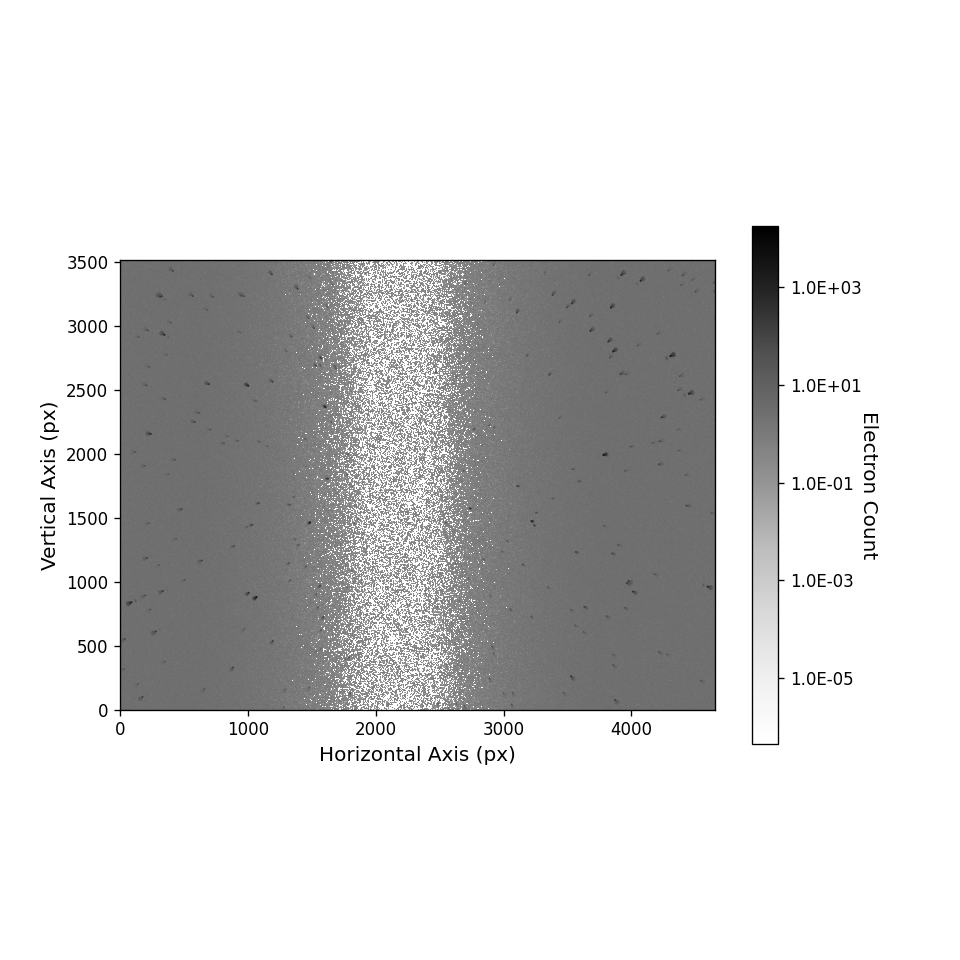

In [36]:
# image = simulate_image(max_mag_widget.value,
#                        ra_widget.value,
#                        dec_widget.value,
#                        t_exp_widget.value * u.s,
#                        bgd_mag_to_arcsec_squared_widget.value,
#                        seeing_arcsec_widget.value * u.arcsec,
#                        temperature_widget.value,
#                        op_mode_widget.value)

In [37]:
# from astropy.io import fits
# hd_dict = [('RA',ra_widget.value,'degrees'),('DEC',dec_widget.value,'degrees'),('t_exp',t_exp_widget.value,'sec'),('sky',bgd_mag_to_arcsec_squared_widget.value,'mag per arcsec squared'),('read_rms',read_noise_rms_widget.value,'electrons per pix'),('seeing',seeing_arcsec_widget.value,'arcsec')]
# hdu = fits.ImageHDU(data=image)

# for hd in hd_dict:
#     hdu.header.append(hd)
# hdu.writeto('example_shifted_narrow.fits',overwrite=True)
